# 机器学习评分卡学习目标：
- 掌握KS值计算方法
- 知道评分映射方法
- 知道XGBoost和LightGBM基本原理
- 掌握使用lightGBM进行特征筛选的方法
- 应用Toad构建评分卡模型


# 1、

In [8]:
# 导入pandas包
import pandas as pd
# 导入numpy包
import numpy as np
# 导入random包
import random
# 导入数学包
import math
# 导入sklearn度量工具
from sklearn import metrics
# 导入sklearn度量工具
from sklearn.metrics import roc_auc_score, roc_curve, auc
# 导入model_selection库包含：数据分割、交叉验证、超参数搜索和模型评估
from sklearn.model_selection import train_test_split
# 导入sklearn线性回归库
from sklearn.linear_model import LogisticRegression

# 1、数据读取
data = pd.read_csv('./file/Bcard.txt')
'''
    数据量：95806行
    字段数量：13
    存在空字段：无
    数据类型：float64、object(2)
    占用内存：9.5+ MB
'''
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95806 entries, 0 to 95805
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   obs_mth       95806 non-null  object 
 1   bad_ind       95806 non-null  float64
 2   uid           95806 non-null  object 
 3   td_score      95806 non-null  float64
 4   jxl_score     95806 non-null  float64
 5   mj_score      95806 non-null  float64
 6   rh_score      95806 non-null  float64
 7   zzc_score     95806 non-null  float64
 8   zcx_score     95806 non-null  float64
 9   person_info   95806 non-null  float64
 10  finance_info  95806 non-null  float64
 11  credit_info   95806 non-null  float64
 12  act_info      95806 non-null  float64
dtypes: float64(11), object(2)
memory usage: 9.5+ MB


,obs_mth,bad_ind,uid,td_score,jxl_score,mj_score,rh_score,zzc_score,zcx_score,person_info,finance_info,credit_info,act_info
0,2018-10-31,0.0,A10000005,0.675349,0.144072,0.186899,0.483640,0.928328,0.369644,-0.322581,0.023810,0.00,0.217949
1,2018-07-31,0.0,A1000002,0.825269,0.398688,0.139396,0.843725,0.605194,0.406122,-0.128677,0.023810,0.00,0.423077
2,2018-09-30,0.0,A1000011,0.315406,0.629745,0.535854,0.197392,0.614416,0.320731,0.062660,0.023810,0.10,0.448718
3,2018-07-31,0.0,A10000481,0.002386,0.609360,0.366081,0.342243,0.870006,0.288692,0.078853,0.071429,0.05,0.179487
4,2018-07-31,0.0,A1000069,0.406310,0.405352,0.783015,0.563953,0.715454,0.512554,-0.261014,0.023810,0.00,0.423077


时间外样本： ['2018-10-31' '2018-07-31' '2018-09-30' '2018-06-30' '2018-11-30']
特征值: person_info    -0.322581
finance_info    0.023810
credit_info     0.000000
act_info        0.217949
td_score        0.675349
jxl_score       0.144072
mj_score        0.186899
Name: 0, dtype: float64 目标值: 0.0
train_ks :  0.4148130573422309
val_ks :  0.3760011269985518


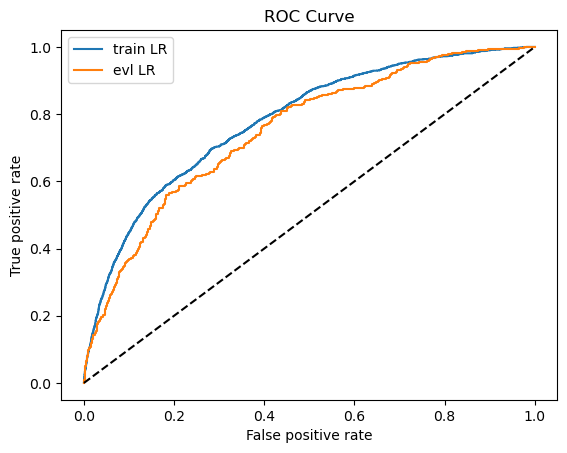

In [38]:
# 1、查看月份分布，用最后一个月作为时间外样本
'''
“时间外样本”（Out-of-Time Sample）是机器学习和数据分析中一个重要的概念，特别是在处理时间序列数据或涉及时间因素的建模任务中。时间外样本是指那些在模型训练过程中未被使用的、时间上更靠后的数据，用于评估模型在新数据上的泛化能力。
'''
print('时间外样本：', data['obs_mth'].unique())

# 2、划分数据集
train = data[data['obs_mth'] != '2018-11-30'].reset_index().copy()
val = data[data['obs_mth'] == '2018-11-30'].reset_index().copy()

# 3、取出建模用到的特征
feature_lst = ['person_info', 'finance_info', 'credit_info', 'act_info', 'td_score', 'jxl_score', 'mj_score',
               'rh_score']

# 4、模型训练
x = train[feature_lst]
y = train['bad_ind']

first_row = x.iloc[0]
print("特征值:", first_row[:-1], "目标值:", y.iloc[0])

val_x = val[feature_lst]
val_y = val['bad_ind']
lr_model = LogisticRegression(C=0.1)
lr_model.fit(x, y)

'''
TPR：表示在所有实际为正的样本中，模型正确预测为正的比例
FPR：表示在所有实际为负的样本中，模型错误预测为正的比例
TPR 衡量模型对正样本的识别能力，而 FPR 衡量模型对负样本的误判能力
'''
# 5、计算测试集和训练集TPR和FPR
# 训练集取出预测值
y_predict = lr_model.predict_proba(x)[:, 1]
# 计算TPR和FPR
fpr_lr_train, tpr_lr_train, _ = roc_curve(y, y_predict)
# 计算KS
train_ks = abs(fpr_lr_train - tpr_lr_train).max()
print('train_ks : ', train_ks)

# 验证集计算预测值
y_predict = lr_model.predict_proba(val_x)[:, 1]
# 计算预测值
fpr_lr, tpr_lr, _ = roc_curve(val_y, y_predict)
# 计算KS值
val_ks = abs(fpr_lr - tpr_lr).max()
print('val_ks : ', val_ks)

# 6、绘制图像
from matplotlib import pyplot as plt

plt.plot(fpr_lr_train, tpr_lr_train, label='train LR')  #绘制训练集ROC
plt.plot(fpr_lr, tpr_lr, label='evl LR')  #绘制验证集ROC
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()


In [44]:
# 导入lightGBM包
import lightgbm as lgb
# 导入sklearn中模型选择工具
from sklearn.model_selection import train_test_split


def lgb_test(train_x, train_y, test_x, test_y):
    '''
    lightGBM进行特征筛选
    :param train_x: 
    :param train_y: 
    :param test_x: 
    :param test_y: 
    :return: 
    '''
    clf = lgb.LGBMClassifier(boosting_type='gbdt',
                             objective='binary',
                             metric='auc',
                             learning_rate=0.1,
                             n_estimators=24,
                             max_depth=5,
                             num_leaves=20,
                             max_bin=45,
                             min_data_in_leaf=6,
                             bagging_fraction=0.6,
                             bagging_freq=0,
                             feature_fraction=0.8, )
    clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (test_x, test_y)], eval_metric='auc')
    return clf, clf.best_score_['valid_1']['auc'],


# 1、数据集划分
train_x, test_x, train_y, test_y = train_test_split(x, y, random_state=0, test_size=0.2)

lgb_model, lgb_auc = lgb_test(train_x, train_y, test_x, test_y)
dict_arr = {
    'name': lgb_model.booster_.feature_name(),
    'importance': lgb_model.feature_importances_
}
feature_importance = pd.DataFrame(dict_arr).sort_values(by=['importance'], ascending=False)

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Info] Number of positive: 1182, number of negative

train_ks :  0.4173085025028503
val_ks :  0.39492219345405577
变量名单： ['person_info', 'finance_info', 'credit_info', 'act_info']
系数： [[ 2.50325724  4.49766948  1.90289775 -1.40657052]]
截距： [-3.92010539]


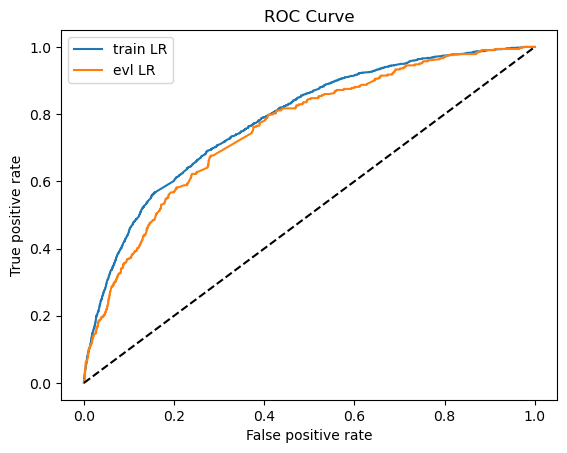

In [47]:
from matplotlib import pyplot as plt

# 1、模型调优，去掉几个特征，重新建模 确定新的特征
feature_lst = ['person_info', 'finance_info', 'credit_info', 'act_info']
x = train[feature_lst]
y = train['bad_ind']

val_x = val[feature_lst]
val_y = val['bad_ind']

# 2、模型训练
lr_model = LogisticRegression(C=0.1)
lr_model.fit(x, y)

# 3、计算FPR和TPR
y_predict = lr_model.predict_proba(x)[:, 1]
fpr_lr_train, tpr_lr_train, _ = roc_curve(y, y_predict)
train_ks = abs(fpr_lr_train - tpr_lr_train).max()
print('train_ks : ', train_ks)

y_predict = lr_model.predict_proba(val_x)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(val_y, y_predict)
val_ks = abs(fpr_lr - tpr_lr).max()
print('val_ks : ', val_ks)

# 4、打印回归系数
print('变量名单：', feature_lst)
print('系数：', lr_model.coef_)
print('截距：', lr_model.intercept_)

# 5、绘图
plt.plot(fpr_lr_train, tpr_lr_train, label='train LR')
plt.plot(fpr_lr, tpr_lr, label='evl LR')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

# 6、生成报告

In [50]:
# 1、准备数据
bins = 20
temp_ = pd.DataFrame()
# 预测结果（坏人概率）
temp_['bad_rate_predict'] = lr_model.predict_proba(val_x)[:, 1]
# 真实结果
temp_['real_bad'] = val_y
# 按照预测坏人概率降序排列
temp_ = temp_.sort_values('bad_rate_predict', ascending=False)
#添加序号列，用于分组
temp_['num'] = [i for i in range(temp_.shape[0])]
#分成20组，为每组添加组号
temp_['num'] = pd.cut(temp_.num, bins=bins, labels=[i for i in range(bins)])

# 2、创建报告
report = pd.DataFrame()
# 计算每一组坏人数量
report['BAD'] = temp_.groupby('num').real_bad.sum().astype(int)
# 计算每一组好人数量
report['GOOD'] = temp_.groupby('num').real_bad.count().astype(int) - report['BAD']
# 累计求和坏人数量
report['BAD_CNT'] = report['BAD'].cumsum()
# 累计求和好人数量
report['GOOD_CNT'] = report['GOOD'].cumsum()
good_total = report.GOOD_CNT.max()
bad_total = report.BAD_CNT.max()
# 计算到当前组坏人比例（占所有坏人比例）
report['BAD_PCTG'] = round(report.BAD_CNT / bad_total, 3)
# 计算当前组坏人概率
report['BADRATE'] = report.apply(lambda x: round(x.BAD / (x.BAD + x.GOOD), 3), axis=1)


# 3、计算KS值
def cal_ks(x):
    '''
    当前箱累计坏人数量/总坏人数量 - 当前箱累计好人数量/好人数量
    :param x: 
    :return: 
    '''
    ks = (x.BAD_CNT / bad_total) - (x.GOOD_CNT / good_total)
    return round(math.fabs(ks), 3)


'''
从报告中可以看出:
1、模型的KS最大值出现在第6箱(编号5),如将箱分的更细,KS值会继续增大,上限为前面通过公式计算出的KS值
2、前4箱的样本占总人数的20%，捕捉负样本占所有负样本的56.4%，如拒绝分数最低的20%的人，可以捕捉到56.4%的负样本。
'''

report['KS'] = report.apply(cal_ks, axis=1)
report



/var/folders/4n/qh91m_wd5fj7fm56fsm72yth0000gp/T/ipykernel_15508/4209485116.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  report['BAD'] = temp_.groupby('num').real_bad.sum().astype(int)
/var/folders/4n/qh91m_wd5fj7fm56fsm72yth0000gp/T/ipykernel_15508/4209485116.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  report['GOOD'] = temp_.groupby('num').real_bad.count().astype(int) - report['BAD']


,BAD,GOOD,BAD_CNT,GOOD_CNT,BAD_PCTG,BADRATE,KS
num,,,,,,,
0,68,731,68,731,0.207,0.085,0.161
1,51,748,119,1479,0.363,0.064,0.268
2,35,764,154,2243,0.470,0.044,0.326
3,32,766,186,3009,0.567,0.040,0.375
4,18,781,204,3790,0.622,0.023,0.380
5,19,780,223,4570,0.680,0.024,0.388
6,15,783,238,5353,0.726,0.019,0.383
7,16,783,254,6136,0.774,0.020,0.382
8,14,785,268,6921,0.817,0.018,0.375


In [51]:
from pyecharts.charts import *
from pyecharts import options as opts
from pylab import *

mpl.rcParams['font.sans-serif'] = ['SimHei']
np.set_printoptions(suppress=True)
pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)
line = (
    Line()
    .add_xaxis(report.index.values.tolist())
    .add_yaxis(
        "分组坏人占比",
        list(report.BADRATE),
        yaxis_index=0,
        color="red",
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(title="评分卡模型表现"),
    )
    .extend_axis(
        yaxis=opts.AxisOpts(
            name="KS值",
            type_="value",
            min_=0,
            max_=0.5,
            position="right",
            axisline_opts=opts.AxisLineOpts(
                linestyle_opts=opts.LineStyleOpts(color="red")
            ),
            axislabel_opts=opts.LabelOpts(formatter="{value}"),
        )

    )
    .add_yaxis(
        "KS",
        list(report['KS']),
        yaxis_index=1,
        color="blue",
        label_opts=opts.LabelOpts(is_show=False),
    )
)
line.render_notebook()

ModuleNotFoundError: No module named 'pyecharts'